# MobileNet

# Fine-tune MobileNet on sign language digits

**Image preparation**

Dataset: hhtp://github.com/ardamavi/Sign-Language-Digits-Daset

    * 10 classes (digits 0-9)
    * Class data:
        * class 0: 205 images
        * class 1: 206 images
        * class 2: 206 images
        * class 3: 206 images
        * class 4: 207 images
        * class 5: 207 images
        * class 6: 207 images
        * class 7: 206 images
        * class 8: 208 images
        * class 9: 204 images
        
    Download data and save in current directory/data/Sign-Language-Digits-Dataset. Extract sub-directories labeleb 0 through 9 and nest directories directly umderneath Sign-Language-Digits-Dataset directory. Directory structure should be like this:
    
    * data.../
       * Sign-Language-Digits-Dataset/
           * 0/
           * 1/
           * ...
           * 9/
    

**Importing necessary packs**

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

**Then organize data into train, valid, test dirs**

In [7]:
os.chdir('D:\ML\DatasetSLDD\Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
            
os.chdir('../..')

*Verifying that's working:*

In [8]:
#for i in range(0, 10):
#    assert len(os.listdir(f'D:/ML/DatasetSLDD/Sign-Language-Digits-Dataset/valid/{i}')) == 30
#    assert len(os.listdir(f'D:/ML/DatasetSLDD/Sign-Language-Digits-Dataset/test/{i}')) == 5

**Preprocessing data**

*First by defining train, valid and test dirs:*

In [9]:
train_path = 'D:/ML/DatasetSLDD/Sign-Language-Digits-Dataset/train'
valid_path = 'D:/ML/DatasetSLDD/Sign-Language-Digits-Dataset/valid'
test_path = 'D:/ML/DatasetSLDD/Sign-Language-Digits-Dataset/test'

*Setting up directory iterators:*

*1) Calling ImageDataGenerator*

*2) Calling the function "tf.keras.applications.mobilenet.preprocess_input"*

*3) Then we flow our directory*

*Finally, -Train_path, targe_size, batch_size*

In [10]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224), batch_size=10
)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=10
)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False
)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [11]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

# Modify Model

**Importing mobilenet**

In [12]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [13]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [14]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [15]:
params = count_params(mobile)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 4231976

**By[-6] we are taking all params but the last 5 ones from the model above and keeping up with the rest for our model**

*We are also going to create a variable called "output"*

*So undesrtand (x) is going to be taken because it is a functional model instead of a Sequential model*

*Also, (x) will pass all of the previous layers stored in (x)*

In [16]:
x = mobile.layers[-6].output
x = GlobalAveragePooling2D()(x)
output = Dense(units=10, activation='softmax')(x)

*Output is all of the mobile netmodel up to sixth layer plus the Dense layer*

In [17]:
model = Model(inputs=mobile.input, outputs=output)

*After both cells above our model will be created*

**Understand, relatively, there're 88 total layers in the model. So we only want to train the last 23 layers**

In [18]:
for layer in model.layers[:-23]: #We want only the last layers to be trainable
    layer.trainable = False #Except for the last 23, make those not trainable

*Now, let's take a look at our new model:*

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [20]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [21]:
params = count_params(model)
assert params['non_trainable_params'] == 1365184
assert params['trainable_params'] == 1873930

**So if you want to check the number of params without looking at the model, you can use the cell bellow**

In [22]:
#params = count_params(model)
#assert params['non_trainable_params'] == expected_non_trainable_params
#assert params['trainable_params'] == expected_trainable_params

# Train Model

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

*Set epochs=30 for better results. You could also set epochs=10, then you'd probably better undertand the accuracy distribution on the confusion matrix.*

In [24]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
172/172 - 265s - loss: 0.6805 - accuracy: 0.8160 - val_loss: 0.3880 - val_accuracy: 0.8900 - 265s/epoch - 2s/step
Epoch 2/30
172/172 - 216s - loss: 0.1170 - accuracy: 0.9842 - val_loss: 0.1038 - val_accuracy: 0.9600 - 216s/epoch - 1s/step
Epoch 3/30
172/172 - 228s - loss: 0.0589 - accuracy: 0.9930 - val_loss: 0.0702 - val_accuracy: 0.9767 - 228s/epoch - 1s/step
Epoch 4/30
172/172 - 236s - loss: 0.0370 - accuracy: 0.9965 - val_loss: 0.0504 - val_accuracy: 0.9867 - 236s/epoch - 1s/step
Epoch 5/30
172/172 - 242s - loss: 0.0249 - accuracy: 0.9982 - val_loss: 0.0426 - val_accuracy: 0.9833 - 242s/epoch - 1s/step
Epoch 6/30
172/172 - 223s - loss: 0.0160 - accuracy: 0.9994 - val_loss: 0.0425 - val_accuracy: 0.9900 - 223s/epoch - 1s/step
Epoch 7/30
172/172 - 245s - loss: 0.0141 - accuracy: 0.9988 - val_loss: 0.0331 - val_accuracy: 0.9900 - 245s/epoch - 1s/step
Epoch 8/30
172/172 - 252s - loss: 0.0133 - accuracy: 0.9982 - val_loss: 0.0315 - val_accuracy: 0.9933 - 252s/epoch - 1s/step


# Predict sign language digits

In [25]:
test_labels = test_batches.classes

In [26]:
predictions = model.predict(x=test_batches, verbose=0)

In [27]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [28]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [29]:
predictions = model.predict(x=test_batches, verbose=0)

In [30]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
       This function plots and prints the confusion matrix.
       Normalization can be applied by setting 'normalize=True'
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


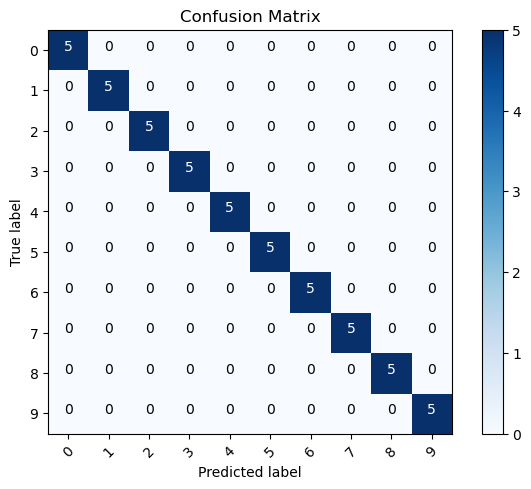

In [31]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')